In [37]:
from collections import Counter
from itertools import product

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os

%matplotlib inline

In [38]:
def golden_figsize(height):
    """
    Assuming height dimension is the shorter one, the width should be:
    (1 + 5**0.5)/2
    
    This function thus returns the (width, height) tuple which is
    computed to be in a golden ratio.
    """
    width = height * (1 + 5**0.5) / 2
    return (width, height)

In [39]:
def is_reassortant(G, node):
    return G.node[node]['reassortant']

# Network Stats on Final Graph

In [40]:
G = nx.read_gpickle('20141103 All IRD Final Graph.pkl')

In [41]:
# How many edges are 'whole genome' and how many are 'reassortment'?

edge_type_counts = Counter()

for sc, sk, d in G.edges(data=True):
    edge_type_counts[d['edge_type']] += 1
    
1 - edge_type_counts['reassortant'] / float(sum(edge_type_counts.values()))

0.7499153546639581

In [42]:
for n, d in G.nodes(data=True):
    in_edge_types = set([d['edge_type'] for sc, sk, d in G.in_edges(n, data=True)])
    if 'reassortant' in in_edge_types:
        G.node[n]['reassortant'] = True
    elif 'full_complement' in in_edge_types:
        G.node[n]['reassortant'] = False
    else:
        G.node[n]['reassortant'] = False

In [43]:
n_reassortants = 0
for n in G.nodes():
    if is_reassortant(G, n):
        n_reassortants += 1
        
n_reassortants

2106

In [44]:
G.edges(data=True)[0]

('A/mallard/Interior Alaska/6MP0160AR1/2006',
 'A/green-winged teal/Interior Alaska/6MP1077/2006',
 {'edge_type': 'full_complement',
  'pwi': 7.7231860000000001,
  'segments': {1: 0.99085800000000002,
   2: 0.88994799999999996,
   3: 0.90987300000000004,
   4: 0.99942500000000001,
   5: 0.93408000000000002,
   6: 1.0,
   7: 0.99900199999999995,
   8: 1.0}})

In [45]:
countries = set([d['country'] for n, d in G.nodes(data=True)])

In [46]:
countryG = nx.DiGraph()
for c1, c2 in product(countries, countries):
    countryG.add_edge(c1, c2, weight=0)
    
for source, sink, data in G.edges(data=True):
    source_country = G.node[source]['country']
    sink_country = G.node[sink]['country']
    
    countryG.edge[source_country][sink_country]['weight'] += 1

In [47]:
host_types = ['Human', 'Avian', 'Swine']
flows = [i for i in product(host_types, host_types)]
flows

[('Human', 'Human'),
 ('Human', 'Avian'),
 ('Human', 'Swine'),
 ('Avian', 'Human'),
 ('Avian', 'Avian'),
 ('Avian', 'Swine'),
 ('Swine', 'Human'),
 ('Swine', 'Avian'),
 ('Swine', 'Swine')]

In [48]:
domainG = nx.DiGraph()
for f in flows:
    domainG.add_edge(f[0], f[1], weight=0)
domainG.edges()

[('Avian', 'Avian'),
 ('Avian', 'Swine'),
 ('Avian', 'Human'),
 ('Swine', 'Avian'),
 ('Swine', 'Swine'),
 ('Swine', 'Human'),
 ('Human', 'Avian'),
 ('Human', 'Swine'),
 ('Human', 'Human')]

In [49]:
for source, sink, data in G.edges(data=True):
    source_host = G.node[source]['host_species']
    sink_host = G.node[sink]['host_species']
    
    for f in flows:
        if f[0] in source_host and f[1] in sink_host:
            domainG.edge[f[0]][f[1]]['weight'] += 1

In [50]:
domainG.edges(data=True)

[('Avian', 'Avian', {'weight': 8938}),
 ('Avian', 'Swine', {'weight': 107}),
 ('Avian', 'Human', {'weight': 191}),
 ('Swine', 'Avian', {'weight': 33}),
 ('Swine', 'Swine', {'weight': 1943}),
 ('Swine', 'Human', {'weight': 325}),
 ('Human', 'Avian', {'weight': 60}),
 ('Human', 'Swine', {'weight': 640}),
 ('Human', 'Human', {'weight': 10736})]

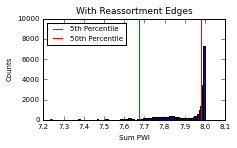

In [51]:
# Histogram of Edges
# What is the distribution of PWIs represented on the edges?
pwis = [d['pwi'] for _, _, d in G.edges(data=True)]
fig = plt.figure(figsize=golden_figsize(2))
plt.hist(pwis, bins=100)
plt.xlabel('Sum PWI')
plt.ylabel('Counts')
plt.title('With Reassortment Edges')
plt.vlines(np.percentile(pwis, 5), 0, 10000, 'green', label='5th Percentile')
plt.vlines(np.percentile(pwis, 50), 0, 10000, 'red', label='50th Percentile')
plt.legend(loc='upper left')
plt.subplots_adjust(left=0.17, right=0.95, top=0.88, bottom=0.18)
plt.savefig('Final Graph PWI Histogram.pdf')

In [52]:
np.percentile(pwis, 5)

7.6738036000000012

In [53]:
subgraphs = [g for g in nx.connected_component_subgraphs(G.to_undirected())]
len(subgraphs)

18

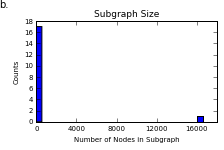

In [54]:
# Subgraph Nodes
subgraph_size = [len(g.nodes()) for g in subgraphs]
fig = plt.figure(figsize=golden_figsize(2))
ax = fig.add_subplot(111)
ax.hist(subgraph_size, bins=30)
ax.set_xlabel('Number of Nodes in Subgraph', fontsize=7)
ax.set_ylabel('Counts', fontsize=7)
ax.get_xaxis().set_ticks(np.arange(0, 18000, 4000))
ax.set_xticklabels(np.arange(0, 18000, 4000), fontsize=7)
ax.set_title('Subgraph Size', fontsize=9)

ax.annotate('b.', xy=(0,1), xycoords='figure fraction', va='top', ha='left')
yticklabels = ax.get_yticklabels()
plt.setp(yticklabels, fontsize=7)
plt.subplots_adjust(bottom=0.2)
plt.savefig('Final Graph Subgraph Sizes.pdf')

H6N1
H3N8
H10N7
H2N3
H3N8
H11N9
H3N2
H3N8
H3N8
H1N1
H6N1
H3N8
H12N5
H8N4
H2N3
H16N3
H1N1


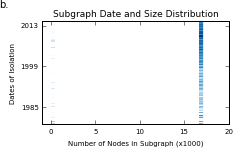

In [55]:
# Let's try making a scatter plot version of this graph.
# y-axis corresponds to the collection dates represented, x-axis corresponds to the size of the subgraph. 
from matplotlib import dates as mdts
from collections import defaultdict
import math
import numpy as np
from matplotlib.colors import LogNorm 

xs = []
ys = []
for g in subgraphs:
    for n, d in g.nodes(data=True):
        cdate = d['collection_date']
        ys.append(mdts.date2num(cdate))
        
        xs.append(len(g.nodes()))
        
        if len(g.nodes()) < 10:
            print(d['subtype'])

yearsFmt = mdts.DateFormatter('%Y')

fig = plt.figure(figsize=golden_figsize(2))
ax = fig.add_subplot(111)
# ax.scatter(xs, ys, alpha=0.05, color='green')
# ax.hexbin(xs, ys, gridsize=(30, 20), cmap='binary', bins='log')
from datetime import datetime as dt
min_date = dt(1980, 1, 1)
max_date = dt(2015, 1, 1)
xbins = np.arange(0, 17001, 500)
ybins = np.arange(mdts.date2num(min_date), mdts.date2num(max_date), 100)
ax.hist2d(xs, ys, norm=LogNorm(), cmap='Blues', bins=[xbins, ybins])

ax.yaxis.set_major_formatter(yearsFmt)
ax.set_xlabel('Number of Nodes in Subgraph (x1000)')
ax.set_ylabel('Dates of Isolation')
ax.xaxis.set_ticklabels([0, 0, 5, 10, 15, 20])
ax.set_xlim(-1000, 20000)

# set min_date
ax.set_ylim(mdts.date2num(min_date), mdts.date2num(max_date))
ax.set_title('Subgraph Date and Size Distribution')
ax.annotate('b.', xy=(0,1), xycoords='figure fraction', ha='left', va='top')

plt.locator_params(axis='y', nbins=4) 
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.18, top=0.90)
plt.savefig('Final Graph Subgraph Sizes and Date Range.pdf')

In [56]:
# Subgraph diameters
# NOTE: This cell takes quite a bit of time to run!
# diameters = [nx.diameter(g) for g in subgraphs]

In [57]:
# diameter_counter = Counter(diameters)
# fig = plt.figure(figsize=golden_figsize(3))
# ax = fig.add_subplot(111)
# ax.bar(diameter_counter.keys(), diameter_counter.values())
# ax.set_xlabel('Graph Diameter')
# ax.set_ylabel('Count')
# ax.set_title('Histogram of Subgraph Diameters \n in Final Graph')
# plt.savefig('Final Graph Diameter Distribution.pdf', bbox_inches='tight')

# Network Stats on Full Complement-Only Graph

In [58]:
fullG = nx.read_gpickle('20141103 All IRD Full Complement Only Graph.pkl')

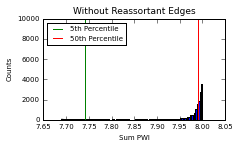

In [59]:
# Histogram of Edges
# What is the distribution of PWIs represented on the edges?
pwis = [d['pwi'] for _, _, d in fullG.edges(data=True)]
fig = plt.figure(figsize=golden_figsize(2))
plt.hist(pwis, bins=100)
plt.xlabel('Sum PWI')
plt.ylabel('Counts')
plt.title('Without Reassortant Edges')
plt.vlines(np.percentile(pwis, 5), 0, 10000, 'green', label='5th Percentile')
plt.vlines(np.percentile(pwis, 50), 0, 10000, 'red', label='50th Percentile')
plt.legend(loc='upper left')
plt.subplots_adjust(left=0.17, right=0.95, top=0.88, bottom=0.18)
plt.savefig('Full Complement Graph PWI Histogram.pdf')

In [60]:
# Identify the number of nodes in the largest two subgraphs.
fullGsubgraphs = [g for g in nx.connected_component_subgraphs(fullG.to_undirected())]
fullGsubgraphs = sorted(fullGsubgraphs, key=lambda x: len(x.nodes()), reverse=True)


In [61]:
# Query the number of nodes
set([d['host_species'] for n, d in fullGsubgraphs[1].nodes(data=True)])
# len(fullGsubgraphs[1].nodes())

{'Ferret', 'Human', 'Swine', 'Turkey/Avian', 'null'}

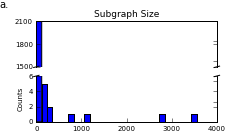

In [62]:
# Subgraph Nodes
fullGsubgraph_size = [len(g.nodes()) for g in fullGsubgraphs]
fig = plt.figure(figsize=golden_figsize(2))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(212)

ax2.hist(fullGsubgraph_size, bins=30)
ax3.hist(fullGsubgraph_size, bins=30)

# Set the y-limits
ax3.set_ylim(0,6)
ax2.set_ylim(1500, 2100)

# Set the y-ticks intervals.
ax3.set_yticks(np.arange(0, 7, 2))
ax2.set_yticks(np.arange(1500, 2101, 300))
ytklabels2 = ax2.get_yticklabels()
plt.setp(ytklabels2, fontsize=7)

ytklabels3 = ax3.get_yticklabels()
plt.setp(ytklabels3, fontsize=7)

# Remove unnecessary spines.
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax3.spines['top'].set_visible(False)

# Remove any unnecessary axes
ax1.get_yaxis().set_ticklabels([])
ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax3.get_xaxis().set_ticks_position('bottom')

# Add in diagonal lines.
d = 0.015
kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((1-d, 1+d), (-d, +d), **kwargs)

kwargs.update(transform=ax3.transAxes)
ax3.plot((-d, +d), (1-d, 1+d), **kwargs)
ax3.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

# Set other plot parameters
# ax3.set_xlabel('Number of Nodes in Subgraph')
ax3.set_ylabel('Counts', fontsize=7)
ax2.set_title('Subgraph Size', fontsize=9)
ax3.get_xaxis().set_ticks(np.arange(0, 5000, 1000))
ax3.get_xaxis().set_ticklabels(np.arange(0, 5000, 1000), fontsize=7)

ax1.annotate('a.', xy=(0,1), xycoords='figure fraction', ha='left', va='top')

plt.subplots_adjust(bottom=0.2)
plt.savefig('Full Complement Graph Subgraph Sizes.pdf')

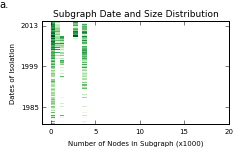

In [63]:
# Let's try making a scatter plot version of this graph.
# y-axis corresponds to the collection dates represented, x-axis corresponds to the size of the subgraph. 
from matplotlib import dates as mdts
from collections import defaultdict
import math
import numpy as np

xs = []
ys = []
for g in fullGsubgraphs:
    for n, d in g.nodes(data=True):
        cdate = d['collection_date']
        ys.append(mdts.date2num(cdate))
        
        xs.append(len(g.nodes()))

yearsFmt = mdts.DateFormatter('%Y')

fig = plt.figure(figsize=golden_figsize(2))
ax = fig.add_subplot(111)
# ax.scatter(xs, ys, alpha=0.05, color='blue')
# ax.hexbin(xs, ys, gridsize=(10,20), cmap='Blues', bins='log')
from datetime import datetime as dt
min_date = dt(1980, 1, 1)
max_date = dt(2015, 1, 1)
xbins = np.arange(0, 17001, 500)
ybins = np.arange(mdts.date2num(min_date), mdts.date2num(max_date), 100)
ax.hist2d(xs, ys, norm=LogNorm(), cmap='Greens', bins=[xbins, ybins])
ax.yaxis.set_major_formatter(yearsFmt)
ax.set_xlabel('Number of Nodes in Subgraph (x1000)')
ax.xaxis.set_ticklabels([0, 0, 5, 10, 15, 20])
ax.set_ylabel('Dates of Isolation')
ax.set_xlim(-1000, 20000)

ax.set_ylim(mdts.date2num(min_date), mdts.date2num(max_date))
ax.set_title('Subgraph Date and Size Distribution')

ax.annotate('a.', xy=(0,1), xycoords='figure fraction', ha='left', va='top')
plt.locator_params(axis='y', nbins=4) 
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.18, top=0.90)
plt.savefig('Full Complement Subgraph Sizes and Date Range.pdf')

In [64]:
# What are the isolates that are not conneced in the big massive graph?

for g in subgraphs:
    if len(g.nodes()) < 5:
        for n in g.nodes():
            print(n, g.node[n])

('A/blue-winged teal/Wisconsin/134/1980', {'reassortant': False, 'collection_date': Timestamp('1980-01-01 00:00:00'), 'country': 'USA', 'subtype': 'H6N1', 'state': 'Wisconsin', 'host_species': 'Blue-Winged Teal/Avian'})
('A/equine/Romania/1/1980', {'collection_date': Timestamp('1980-01-01 00:00:00'), 'country': 'Romania', 'reassortant': False, 'host_species': 'Horse', 'subtype': 'H3N8'})
('A/mallard/Wisconsin/42/1981', {'reassortant': False, 'collection_date': Timestamp('1981-01-01 00:00:00'), 'country': 'USA', 'subtype': 'H10N7', 'state': 'Wisconsin', 'host_species': 'Mallard/Avian'})
('A/swine/Missouri/4296424/2006', {'reassortant': False, 'collection_date': Timestamp('2006-01-01 00:00:00'), 'country': 'USA', 'subtype': 'H2N3', 'state': 'Missouri', 'host_species': 'Swine'})
('A/American green-winged teal/Illinois/11OS4814/2011', {'reassortant': False, 'collection_date': Timestamp('2011-10-22 00:00:00'), 'country': 'USA', 'subtype': 'H3N8', 'state': 'Illinois', 'host_species': 'Avian'

In [65]:
[n for n in G.nodes() if G.node[n]['subtype'] == 'H11N7']

['A/ruddy turnstone/New Jersey/471606/2001',
 'A/shorebird/Delaware Bay/284/1999',
 'A/ruddy turnstone/Delaware Bay/149/1999',
 'A/shorebird/Delaware Bay/273/1999']

In [66]:
# Data Dump
G.nodes(data=True)[0]

('A/mallard/Interior Alaska/6MP0160AR1/2006',
 {'collection_date': Timestamp('2006-08-12 00:00:00'),
  'country': 'USA',
  'host_species': 'Mallard/Avian',
  'reassortant': False,
  'state': 'Interior Alaska',
  'subtype': 'H3N8'})

In [67]:
import pandas as pd

# Node List Dump
node_list = []
for n, d in G.nodes(data=True):
    data = dict()
    data['strain_name'] = n
    for k, v in d.items():
        data[k] = v
        
    node_list.append(data)
    
pd.DataFrame(node_list).to_csv('20141103 All IRD Node List.csv')

In [68]:
# Edge List Dump
G.edges(data=True)[0]

('A/mallard/Interior Alaska/6MP0160AR1/2006',
 'A/green-winged teal/Interior Alaska/6MP1077/2006',
 {'edge_type': 'full_complement',
  'pwi': 7.7231860000000001,
  'segments': {1: 0.99085800000000002,
   2: 0.88994799999999996,
   3: 0.90987300000000004,
   4: 0.99942500000000001,
   5: 0.93408000000000002,
   6: 1.0,
   7: 0.99900199999999995,
   8: 1.0}})

In [69]:
edge_list = []
for sc, sk, d in G.edges(data=True):
    data = dict()
    data['source'] = sc
    data['sink'] = sk
    for k, v in d.items():
        if isinstance(v, dict):
            for s, p in v.items():
                data['segment{0}'.format(s)] = p
        else:
            data[k] = v
    edge_list.append(data)
    
pd.DataFrame(edge_list).to_csv('20141103 All IRD Edge List.csv')

In [70]:
# Subgraph diameters
# NOTE: This cell takes quite a bit of time to run!
# fullGdiameters = [nx.diameter(g) for g in fullGsubgraphs]

In [71]:
# fullGdiameter_counter = Counter(fullGdiameters)
# plt.bar(fullGdiameter_counter.keys(), fullGdiameter_counter.values())
# plt.xlabel('Graph Diameter')
# plt.ylabel('Count')
# plt.title('Histogram of Subgraph Diameters \n in Full Complement Graph')
# plt.savefig('Full Complement Graph Diameter Distribution.pdf', bbox_inches='tight')

In [72]:
# For further analysis, write the subgraphs to disk
# if os.getcwd().split('/')[-1] == 'All_IRD_Analysis_Run2':
#     os.chdir('subgraph_pkl')

# for i, g in enumerate(subgraphs):
#     nx.write_gpickle(G.subgraph(g.nodes()), 'subgraph{0}.pkl'.format(i))
    
    
# if os.getcwd().split('/')[-1] == 'subgraph_pkl':
#     os.chdir('..')